In [1]:
from pymongo import MongoClient
# from sshtunnel import SSHTunnelForwarder
import pymongo
from tqdm import tqdm
import os
import re

import numpy as np
import pandas as pd

import dateutil.parser
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Wed Aug  3 00:42:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 67%   79C    P2   159W / 260W |   4252MiB / 11019MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 30%   

# MongoDB

In [4]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_us = db.rm_patent_us
    db_rm_cn = db.rm_patent_cn
    db_rm_de = db.rm_patent_de
    
    db_rm_us_2020 = db.rm_patent_us_2020
    db_rm_cn_2020 = db.rm_patent_cn_2020
    db_rm_de_2020 = db.rm_patent_de_2020
    
except errors.ConnectionFailure as err:
    print(err)

In [5]:
db_rm_de

Collection(Database(MongoClient(host=['140.117.69.70:30241'], document_class=dict, tz_aware=False, connect=True, authmechanism='SCRAM-SHA-1'), 'eva'), 'rm_patent_de')

# DE Data

In [6]:
data_5 = pd.read_csv("../rm_company_cpc_cn_5.csv")
data_10 = pd.read_csv("../rm_company_cpc_cn_10.csv")

In [7]:
data_5.head()

,company,A01,A23,A41,A42,A43,A44,A45,A46,A47,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3M innovation intellectual property Co.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3b Technology Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3d-Oxset Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Mo Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data_10.head()

,company,A01,A21,A23,A24,A41,A42,A43,A44,A45,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,1230 Intelligent Technology Haian Co ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2,"5G IP HOLDINGS, LLC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
3,63921 Troops of PLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,A Field Of Shenzhen Science And Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
data_all = pd.concat([data_5,data_10], join='outer')

In [10]:
data_all.fillna(value=0, inplace=True)
data_all

,company,A01,A23,A41,A42,A43,A44,A45,A46,A47,...,C13,C30,D05,E06,F15,F22,F26,F41,F42,G12
0,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3M innovation intellectual property Co.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3b Technology Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3d-Oxset Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Mo Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,eMemory Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,iDevices LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7031,iRobot Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7032,nChain Holdings Ltd,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_sum = pd.DataFrame(np.sum(data_all.values, axis=0), columns=['sum'])

In [12]:
df_sum["row"]=list(data_all.columns)

In [13]:
# 找出總數top10的CPC
cn_cpc_top10 = df_sum.iloc[1:,:].sort_values(by=['sum'],ascending=False).head(10)
cn_cpc_top10

,sum,row
100,97592.0,H04
89,22463.0,G06
84,7983.0,G01
97,6950.0,H01
102,6477.0,Y02
91,5163.0,G08
10,3489.0,A61
88,3258.0,G05
98,2785.0,H02
47,2583.0,C08


# US Data

In [14]:
data_5 = pd.read_csv("../rm_company_cpc_us_5.csv")
data_10 = pd.read_csv("../rm_company_cpc_us_10.csv")

In [15]:
data_5.head()

,company,A01,A23,A41,A42,A44,A46,A47,A61,A62,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,3d-Oxides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABB Schweiz AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0,1.0,0.0
2,ADVANERGY Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,8.0,0.0,3.0,4.0,0.0
3,AFI Licensing LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,AFIRMA CONSULTING & TECHNOLOGIES SL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0


In [16]:
data_10.head()

,company,A01,A21,A22,A23,A24,A41,A42,A43,A44,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,#glowontech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0Chain LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2,10353744 Canada Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
3,10757616 Canada Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,14.0,0.0,0.0,0.0,1.0,1.0,0.0
4,12a Systems Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
data_all = pd.concat([data_5,data_10], join='outer')

In [18]:
data_all.fillna(value=0, inplace=True)
data_all

,company,A01,A23,A41,A42,A44,A46,A47,A61,A62,...,E21,F02,F17,F22,F23,F26,F27,F41,F42,G12
0,3d-Oxides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABB Schweiz AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ADVANERGY Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFI Licensing LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFIRMA CONSULTING & TECHNOLOGIES SL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4636,incNETWORKS Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4637,mSignia Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4638,nChain Holdings Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4639,u-blox AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_sum = pd.DataFrame(np.sum(data_all.values, axis=0), columns=['sum'])

In [20]:
df_sum["row"]=list(data_all.columns)

In [21]:
# 找出總數top10的CPC
us_cpc_top10 = df_sum.iloc[1:,:].sort_values(by=['sum'],ascending=False).head(10)
us_cpc_top10

,sum,row
67,223814.0,H04
56,81402.0,G06
64,17423.0,H01
51,8619.0,G01
8,8404.0,A61
66,6063.0,H03
21,5827.0,B60
58,5108.0,G08
69,4731.0,Y02
55,4560.0,G05


# CN Data

In [53]:
data_5 = pd.read_csv("../rm_company_cpc_cn_5.csv")
data_10 = pd.read_csv("../rm_company_cpc_cn_10.csv")

In [54]:
data_5.head()

,company,A01,A23,A41,A42,A43,A44,A45,A46,A47,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3M innovation intellectual property Co.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3b Technology Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3d-Oxset Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Mo Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
data_10.head()

,company,A01,A21,A23,A24,A41,A42,A43,A44,A45,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,1230 Intelligent Technology Haian Co ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2,"5G IP HOLDINGS, LLC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
3,63921 Troops of PLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,A Field Of Shenzhen Science And Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [56]:
data_all = pd.concat([data_5,data_10], join='outer')

In [57]:
data_all.fillna(value=0, inplace=True)
data_all

,company,A01,A23,A41,A42,A43,A44,A45,A46,A47,...,C13,C30,D05,E06,F15,F22,F26,F41,F42,G12
0,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3M innovation intellectual property Co.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3b Technology Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3d-Oxset Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Mo Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029,eMemory Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,iDevices LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7031,iRobot Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7032,nChain Holdings Ltd,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df_sum = pd.DataFrame(np.sum(data_all.values, axis=0), columns=['sum'])

In [59]:
df_sum["row"]=list(data_all.columns)

In [60]:
# 找出總數top10的CPC
cn_cpc_top10 = df_sum.iloc[1:,:].sort_values(by=['sum'],ascending=False).head(10)
cn_cpc_top10

,sum,row
100,97592.0,H04
89,22463.0,G06
84,7983.0,G01
97,6950.0,H01
102,6477.0,Y02
91,5163.0,G08
10,3489.0,A61
88,3258.0,G05
98,2785.0,H02
47,2583.0,C08


# 畫出各國CPC barchart

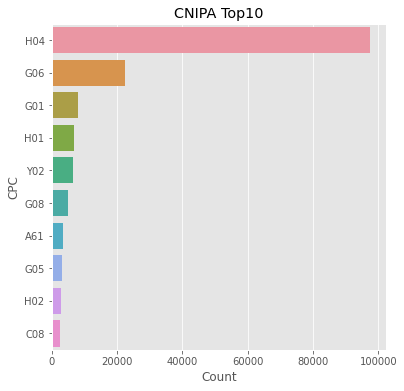

In [73]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')

sns.barplot(x='sum', y='row', data=cn_cpc_top10)
plt.xlabel("Count")
plt.ylabel("CPC")
plt.title("CNIPA Top10")

plt.show()

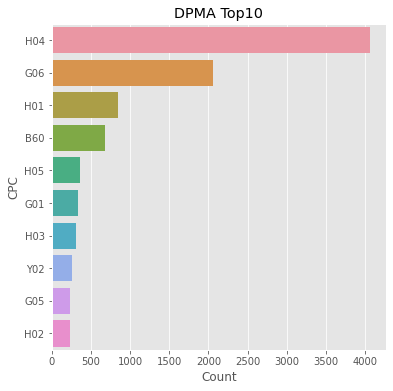

In [74]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')

sns.barplot(x='sum', y='row', data=de_cpc_top10)
plt.xlabel("Count")
plt.ylabel("CPC")
plt.title("DPMA Top10")

plt.show()

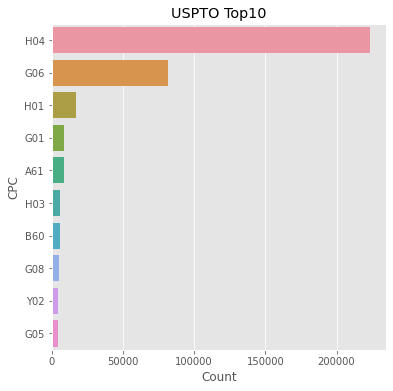

In [76]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')

sns.barplot(x='sum', y='row', data=us_cpc_top10)
plt.xlabel("Count")
plt.ylabel("CPC")
plt.title("USPTO Top10")

plt.show()

# 分別計算各國各年分CPC數量

## DE

In [ ]:
de_ls = []
for i in range(2010,2021):
    try:
        cpc_df = pd.read_csv("rm_company_cpc_de_{}.csv".format(i))
        
        c_ls = []
        for k in cpc_ls:
            try:
                # print(np.sum(cpc_df.loc[:,k].values, axis=0))
                c_ls.append(np.sum(cpc_df.loc[:,k].values, axis=0))
            except:    
                c_ls.append(0)
        
        print(i,c_ls)
        de_ls.append(c_ls)
    except:
        # print(i,list(np.zeros(10)))
        print(i,"=============================")
        de_ls.append(list(np.zeros(10)))

2010 =============================
2011 =============================
2012 [12.0, 17.0, 6.0, 0, 0, 5.0, 0, 0, 0, 0]
2013 [7.0, 3.0, 6.0, 6.0, 0, 2.0, 0, 0, 0, 0]
2014 [75.0, 7.0, 129.0, 1.0, 0, 8.0, 1.0, 0, 0, 2.0]
2015 [78.0, 15.0, 1.0, 8.0, 19.0, 4.0, 10.0, 0, 6.0, 38.0]
2016 [441.0, 98.0, 30.0, 17.0, 0, 16.0, 18.0, 4.0, 9.0, 12.0]
2017 [1027.0, 324.0, 166.0, 46.0, 50.0, 50.0, 21.0, 36.0, 42.0, 6.0]
2018 [1217.0, 428.0, 154.0, 132.0, 21.0, 50.0, 58.0, 122.0, 63.0, 145.0]
2019 [665.0, 363.0, 237.0, 79.0, 35.0, 64.0, 57.0, 57.0, 77.0, 56.0]
2020 [538.0, 802.0, 121.0, 45.0, 55.0, 55.0, 15.0, 463.0, 38.0, 58.0]


In [ ]:
de_ls

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [12.0, 17.0, 6.0, 0, 0, 5.0, 0, 0, 0, 0],
 [7.0, 3.0, 6.0, 6.0, 0, 2.0, 0, 0, 0, 0],
 [75.0, 7.0, 129.0, 1.0, 0, 8.0, 1.0, 0, 0, 2.0],
 [78.0, 15.0, 1.0, 8.0, 19.0, 4.0, 10.0, 0, 6.0, 38.0],
 [441.0, 98.0, 30.0, 17.0, 0, 16.0, 18.0, 4.0, 9.0, 12.0],
 [1027.0, 324.0, 166.0, 46.0, 50.0, 50.0, 21.0, 36.0, 42.0, 6.0],
 [1217.0, 428.0, 154.0, 132.0, 21.0, 50.0, 58.0, 122.0, 63.0, 145.0],
 [665.0, 363.0, 237.0, 79.0, 35.0, 64.0, 57.0, 57.0, 77.0, 56.0],
 [538.0, 802.0, 121.0, 45.0, 55.0, 55.0, 15.0, 463.0, 38.0, 58.0]]

In [ ]:
de_df = pd.DataFrame(de_ls, index=list(range(2010,2021)), columns=cpc_ls)
de_df

,H04,G06,H01,G01,A61,Y02,G08,B60,G05,H03
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,12.0,17.0,6.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2013,7.0,3.0,6.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0
2014,75.0,7.0,129.0,1.0,0.0,8.0,1.0,0.0,0.0,2.0
2015,78.0,15.0,1.0,8.0,19.0,4.0,10.0,0.0,6.0,38.0
2016,441.0,98.0,30.0,17.0,0.0,16.0,18.0,4.0,9.0,12.0
2017,1027.0,324.0,166.0,46.0,50.0,50.0,21.0,36.0,42.0,6.0
2018,1217.0,428.0,154.0,132.0,21.0,50.0,58.0,122.0,63.0,145.0
2019,665.0,363.0,237.0,79.0,35.0,64.0,57.0,57.0,77.0,56.0


## CN

In [ ]:
cn_ls = []
for i in range(2010,2021):
    try:
        cpc_df = pd.read_csv("rm_company_cpc_cn_{}.csv".format(i))
        
        c_ls = []
        for k in cpc_ls:
            try:
                # print(np.sum(cpc_df.loc[:,k].values, axis=0))
                c_ls.append(np.sum(cpc_df.loc[:,k].values, axis=0))
            except:    
                c_ls.append(0)
        
        print(i,c_ls)
        cn_ls.append(c_ls)
    except:
        # print(i,list(np.zeros(10)))
        print("=============================")
        cn_ls.append(list(np.zeros(10)))

2010 [74.0, 5.0, 4.0, 4.0, 48.0, 34.0, 0, 7.0, 5.0, 15.0]
2011 [148.0, 18.0, 212.0, 24.0, 197.0, 142.0, 0, 49.0, 3.0, 0]
2012 [171.0, 13.0, 659.0, 67.0, 202.0, 112.0, 0, 18.0, 10.0, 7.0]
2013 [207.0, 63.0, 181.0, 85.0, 127.0, 114.0, 0, 147.0, 34.0, 19.0]
2014 [269.0, 80.0, 104.0, 50.0, 147.0, 75.0, 40.0, 125.0, 8.0, 0]
2015 [1089.0, 277.0, 136.0, 98.0, 228.0, 134.0, 67.0, 22.0, 60.0, 2.0]
2016 [6956.0, 1597.0, 840.0, 390.0, 330.0, 426.0, 287.0, 134.0, 178.0, 114.0]
2017 [22074.0, 3693.0, 1280.0, 1112.0, 627.0, 1105.0, 937.0, 396.0, 623.0, 394.0]
2018 [27768.0, 4027.0, 1191.0, 1696.0, 617.0, 1223.0, 1266.0, 350.0, 895.0, 436.0]
2019 [23179.0, 5094.0, 1147.0, 2009.0, 445.0, 1472.0, 1179.0, 279.0, 716.0, 132.0]
2020 [15040.0, 7296.0, 1176.0, 2342.0, 502.0, 1524.0, 1293.0, 307.0, 690.0, 133.0]


In [ ]:
cn_ls

[[74.0, 5.0, 4.0, 4.0, 48.0, 34.0, 0, 7.0, 5.0, 15.0],
 [148.0, 18.0, 212.0, 24.0, 197.0, 142.0, 0, 49.0, 3.0, 0],
 [171.0, 13.0, 659.0, 67.0, 202.0, 112.0, 0, 18.0, 10.0, 7.0],
 [207.0, 63.0, 181.0, 85.0, 127.0, 114.0, 0, 147.0, 34.0, 19.0],
 [269.0, 80.0, 104.0, 50.0, 147.0, 75.0, 40.0, 125.0, 8.0, 0],
 [1089.0, 277.0, 136.0, 98.0, 228.0, 134.0, 67.0, 22.0, 60.0, 2.0],
 [6956.0, 1597.0, 840.0, 390.0, 330.0, 426.0, 287.0, 134.0, 178.0, 114.0],
 [22074.0, 3693.0, 1280.0, 1112.0, 627.0, 1105.0, 937.0, 396.0, 623.0, 394.0],
 [27768.0, 4027.0, 1191.0, 1696.0, 617.0, 1223.0, 1266.0, 350.0, 895.0, 436.0],
 [23179.0, 5094.0, 1147.0, 2009.0, 445.0, 1472.0, 1179.0, 279.0, 716.0, 132.0],
 [15040.0, 7296.0, 1176.0, 2342.0, 502.0, 1524.0, 1293.0, 307.0, 690.0, 133.0]]

In [ ]:
cn_df = pd.DataFrame(cn_ls, index=list(range(2010,2021)), columns=cpc_ls)
cn_df

,H04,G06,H01,G01,A61,Y02,G08,B60,G05,H03
2010,74.0,5.0,4.0,4.0,48.0,34.0,0.0,7.0,5.0,15.0
2011,148.0,18.0,212.0,24.0,197.0,142.0,0.0,49.0,3.0,0.0
2012,171.0,13.0,659.0,67.0,202.0,112.0,0.0,18.0,10.0,7.0
2013,207.0,63.0,181.0,85.0,127.0,114.0,0.0,147.0,34.0,19.0
2014,269.0,80.0,104.0,50.0,147.0,75.0,40.0,125.0,8.0,0.0
2015,1089.0,277.0,136.0,98.0,228.0,134.0,67.0,22.0,60.0,2.0
2016,6956.0,1597.0,840.0,390.0,330.0,426.0,287.0,134.0,178.0,114.0
2017,22074.0,3693.0,1280.0,1112.0,627.0,1105.0,937.0,396.0,623.0,394.0
2018,27768.0,4027.0,1191.0,1696.0,617.0,1223.0,1266.0,350.0,895.0,436.0
2019,23179.0,5094.0,1147.0,2009.0,445.0,1472.0,1179.0,279.0,716.0,132.0


## US

In [ ]:
us_ls = []
for i in range(2010,2021):
    try:
        cpc_df = pd.read_csv("rm_company_cpc_us_{}.csv".format(i))
        
        c_ls = []
        for k in cpc_ls:
            try:
                # print(np.sum(cpc_df.loc[:,k].values, axis=0))
                c_ls.append(np.sum(cpc_df.loc[:,k].values, axis=0))
            except:    
                c_ls.append(0)
        
        print(i,c_ls)
        us_ls.append(c_ls)
    except:
        # print(i,list(np.zeros(10)))
        print("=============================")
        us_ls.append(list(np.zeros(10)))

2010 [86.0, 30.0, 14.0, 12.0, 0, 2.0, 0, 0, 0, 0]
2011 [544.0, 67.0, 19.0, 5.0, 2.0, 11.0, 4.0, 0, 0, 3.0]
2012 [940.0, 62.0, 10.0, 12.0, 0, 32.0, 5.0, 16.0, 3.0, 0]
2013 [881.0, 80.0, 46.0, 23.0, 0, 26.0, 10.0, 0, 4.0, 5.0]
2014 [3526.0, 749.0, 457.0, 85.0, 103.0, 95.0, 52.0, 29.0, 43.0, 19.0]
2015 [10495.0, 3562.0, 1069.0, 362.0, 282.0, 340.0, 233.0, 70.0, 182.0, 168.0]
2016 [18470.0, 6489.0, 2427.0, 590.0, 821.0, 455.0, 422.0, 153.0, 438.0, 345.0]
2017 [28819.0, 10359.0, 3058.0, 1253.0, 1381.0, 678.0, 912.0, 467.0, 523.0, 968.0]
2018 [46629.0, 17070.0, 3587.0, 1661.0, 1808.0, 994.0, 953.0, 996.0, 982.0, 1987.0]
2019 [61580.0, 24818.0, 3278.0, 2556.0, 2052.0, 1151.0, 1604.0, 2072.0, 1425.0, 1187.0]
2020 [50896.0, 17677.0, 3372.0, 2039.0, 1935.0, 894.0, 899.0, 1986.0, 927.0, 1350.0]


In [ ]:
us_ls

[[86.0, 30.0, 14.0, 12.0, 0, 2.0, 0, 0, 0, 0],
 [544.0, 67.0, 19.0, 5.0, 2.0, 11.0, 4.0, 0, 0, 3.0],
 [940.0, 62.0, 10.0, 12.0, 0, 32.0, 5.0, 16.0, 3.0, 0],
 [881.0, 80.0, 46.0, 23.0, 0, 26.0, 10.0, 0, 4.0, 5.0],
 [3526.0, 749.0, 457.0, 85.0, 103.0, 95.0, 52.0, 29.0, 43.0, 19.0],
 [10495.0, 3562.0, 1069.0, 362.0, 282.0, 340.0, 233.0, 70.0, 182.0, 168.0],
 [18470.0, 6489.0, 2427.0, 590.0, 821.0, 455.0, 422.0, 153.0, 438.0, 345.0],
 [28819.0, 10359.0, 3058.0, 1253.0, 1381.0, 678.0, 912.0, 467.0, 523.0, 968.0],
 [46629.0,
  17070.0,
  3587.0,
  1661.0,
  1808.0,
  994.0,
  953.0,
  996.0,
  982.0,
  1987.0],
 [61580.0,
  24818.0,
  3278.0,
  2556.0,
  2052.0,
  1151.0,
  1604.0,
  2072.0,
  1425.0,
  1187.0],
 [50896.0,
  17677.0,
  3372.0,
  2039.0,
  1935.0,
  894.0,
  899.0,
  1986.0,
  927.0,
  1350.0]]

In [ ]:
us_df = pd.DataFrame(us_ls, index=list(range(2010,2021)), columns=cpc_ls)
us_df

,H04,G06,H01,G01,A61,Y02,G08,B60,G05,H03
2010,86.0,30.0,14.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0
2011,544.0,67.0,19.0,5.0,2.0,11.0,4.0,0.0,0.0,3.0
2012,940.0,62.0,10.0,12.0,0.0,32.0,5.0,16.0,3.0,0.0
2013,881.0,80.0,46.0,23.0,0.0,26.0,10.0,0.0,4.0,5.0
2014,3526.0,749.0,457.0,85.0,103.0,95.0,52.0,29.0,43.0,19.0
2015,10495.0,3562.0,1069.0,362.0,282.0,340.0,233.0,70.0,182.0,168.0
2016,18470.0,6489.0,2427.0,590.0,821.0,455.0,422.0,153.0,438.0,345.0
2017,28819.0,10359.0,3058.0,1253.0,1381.0,678.0,912.0,467.0,523.0,968.0
2018,46629.0,17070.0,3587.0,1661.0,1808.0,994.0,953.0,996.0,982.0,1987.0
2019,61580.0,24818.0,3278.0,2556.0,2052.0,1151.0,1604.0,2072.0,1425.0,1187.0


# 計算各國CPC類別總數量

In [ ]:
us_5 = pd.read_csv("../rm_company_cpc_us_5.csv")
us_10 = pd.read_csv("../rm_company_cpc_us_10.csv")

In [ ]:
us_all = pd.concat([us_5,us_10], join='outer')

In [ ]:
len(list(us_all.columns))-1

118

In [ ]:
de_5 = pd.read_csv("../rm_company_cpc_de_us_5.csv")
de_10 = pd.read_csv("../rm_company_cpc_de_us_10.csv")

In [ ]:
de_all = pd.concat([de_5,de_10], join='outer')

In [ ]:
len(list(de_all.columns))-1

121

In [ ]:
cn_5 = pd.read_csv("../rm_company_cpc_cn_us_5.csv")
cn_10 = pd.read_csv("../rm_company_cpc_cn_us_10.csv")

In [ ]:
cn_all = pd.concat([cn_5,cn_10], join='outer')

In [ ]:
len(list(cn_all.columns))-1

125

In [ ]:
cpc_df = pd.read_csv("rm_company_cpc_us_2018.csv")

In [ ]:
cpc_df

,company,A01,A21,A23,A41,A42,A43,A45,A46,A47,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,0Chain LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1,2689090 Canada Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
2,2you Io Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
3,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3a Logics Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,Zuna Inc,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
1526,Zyter Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
1527,eBay Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1528,eMemory Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0
